This script will attempt to process and plot echosounder and amplitude raw as a means of understanding sediment characteristics.

In [2]:
### Code to read in h5 files as detailed in the first guidebook
# Import necessary packages
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [3]:
deployment_num = 1
sensor_id = "E1_103071"
#directory_initial_user_path = r"/Volumes/BOEM/"  # Katherine
# directory_initial_user_path = r"/Volumes/kanarde/BOEM/"  # Brooke
directory_initial_user_path = r"Z:/"  # Levi

In [4]:
# Create dictionary for each sensor
dirpath=os.path.join(directory_initial_user_path, f"deployment_{deployment_num}/Raw/",f"{sensor_id}_hdf",'Group27')  # path to the directory containing the h5 files
files = os.listdir(dirpath) # list of files for the sensor
raw = {}
for file in files:
    file_path = os.path.join(dirpath, file)  # file path
    df = pd.read_hdf(file_path)  # read the file into a Pandas rawframe
    file_name = file.split('.')[0]  # file name 
    print(file_name)
    raw[file_name] = df  # store rawframe
globals()[f"raw_{sensor_id}"] = raw

Burst_NCells
Burst_CellSize
EchoBlankingDistance
EchoCellSize
EchoFrequency
Beam2xyz
EchoTransmitLength
Burst_SampleRate
Burst_VelBeam
Burst_VertAmplitude
Burst_CorBeam
Burst_AmpBeam
Burst_Time
Burst_Pressure
Burst_Heading
Burst_Pitch
Burst_Roll
Echo1
Echo2


In [5]:
# Create dictionary for each sensor
dirpath=os.path.join(directory_initial_user_path, f"deployment_{deployment_num}/Processed/",f"{sensor_id}",'Group27')  # path to the directory containing the h5 files
files = os.listdir(dirpath) # list of files for the sensor
Data = {}
for file in files:
    file_path = os.path.join(dirpath, file)  # file path
    df = pd.read_hdf(file_path)  # read the file into a Pandas rawframe
    file_name = file.split('.')[0]  # file name 
    print(file_name)
    Data[file_name] = df  # store rawframe
globals()[f"Data_{sensor_id}"] = Data

AbsVel
Time
EastVel
NorthVel
VertVel
ErrVel
Heading
Roll
Pitch
Pressure
VelBeamCorr1
VelBeamCorr2
VelBeamCorr3
VelBeamCorr4
CellDepth
Echo1
Echo2


In [6]:
# Create cell depth vector
vector = np.arange(1, raw["Burst_NCells"][0][0] + 1)

# Calculate the depth of each cell
raw["CellDepth"] = (
        raw["EchoBlankingDistance"][0].iloc[0]
        + vector * raw["Burst_CellSize"][0].iloc[0]
)

#Create echo cell depth vector
raw['EchoNCells'] = raw['Echo1'].shape[1]  # Number of echo cells
vector = np.arange(1, raw["EchoNCells"] + 1)

# Calculate the depth of each cell
raw["CellDepth_echo"] = (
        raw["EchoBlankingDistance"][0].iloc[0]
        + vector * raw["EchoCellSize"][0].iloc[0]
)

Sr = raw['Burst_SampleRate']
CorrThresh = (
        0.3 + 0.4 * (Sr / 25) ** 0.5
)  # Threshold for correlation values as found in Elgar

row, col = raw['Burst_VertAmplitude'].shape
row1, col2 = raw['Echo1'].shape


isbad = np.zeros((row, col))  # Initialize mask for above surface measurements
echobad = np.zeros((row1, col2))


# Apply mask for surface measurements
for i in range(len(isbad)):
    Depth_Thresh = (
            raw["Burst_Pressure"].iloc[i][0] * np.cos(25 * np.pi / 180)
            - raw["Burst_CellSize"][0].iloc[0]
    )
    isbad[i, :] = raw["CellDepth"] >= Depth_Thresh

isbad = isbad.astype(bool)
raw["DepthThresh"] = isbad


# Apply mask for surface measurements
for i in range(len(echobad)):
    Depth_Thresh1 = (
            raw["Burst_Pressure"].iloc[i][0] * np.cos(25 * np.pi / 180)
            - raw["EchoCellSize"][0].iloc[0]
    )
    echobad[i, :] = raw["CellDepth_echo"] >= Depth_Thresh1
echobad = echobad.astype(bool)
raw["EchoDepthThresh"] = echobad


# Mask the data 
raw["Echo1"] = raw["Echo1"].mask(echobad, np.nan)
raw["Echo2"] = raw["Echo2"].mask(echobad, np.nan)

#mask the data
raw[f"Burst_VertAmplitude"] = raw[f"Burst_VertAmplitude"].mask(isbad, np.nan)


In [7]:
#Attempts at sediment attentuation of the amplitude data 
salinity = 35 # Salinity in ppt

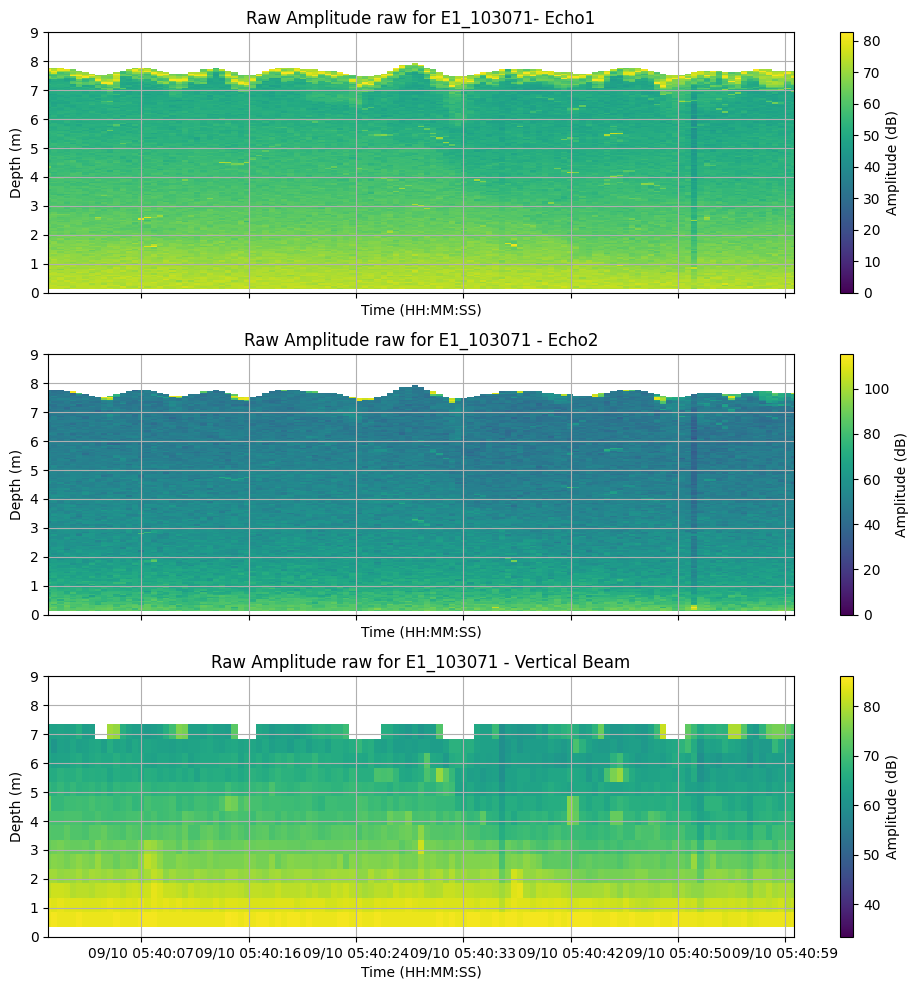

In [8]:
#Plot the raw amplitude raw and make the required cell depth vectors
# Create cell depth vector
vector = np.arange(1, raw["Burst_NCells"][0][0] + 1)

# Calculate the depth of each cell
raw["CellDepth"] = (
        raw["EchoBlankingDistance"][0].iloc[0]
        + vector * raw["Burst_CellSize"][0].iloc[0]
)

#Create echo cell depth vector
raw['EchoNCells'] = raw['Echo1'].shape[1]  # Number of echo cells
# Create cell depth vector for echoes
vector = np.arange(1, raw["EchoNCells"] + 1)

# Calculate the depth of each cell
raw["CellDepth_echo"] = (
        raw["EchoBlankingDistance"][0].iloc[0]
        + vector * raw["EchoCellSize"][0].iloc[0])

# Plot the raw amplitude raw for Echo1 and Echo2 and the Vertical Beam using meshgrids
#Echo1 and Echo2 have shapes [Sample,Cells] and Vertical Beam has shape [Sample,Cells] where the Echo cell depth maps the depths of each cell for the echoes, whilw the Vertical Beam uses normal cell depth
fig, (axs1,axs2,axs3)  = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

fig.colorbar(axs1.pcolormesh(
    raw["Burst_Time"][0],
    raw["CellDepth_echo"],
    raw["Echo1"].T,
    shading="auto",
    cmap="viridis", 
),ax=axs1, label='Amplitude (dB)')
axs1.set_title(f"Raw Amplitude raw for {sensor_id}- Echo1")
fig.colorbar(axs2.pcolormesh(
    raw["Burst_Time"][0],
    raw["CellDepth_echo"],
    raw["Echo2"].T,
    shading="auto",
    cmap="viridis",
),ax=axs2, label='Amplitude (dB)')
axs2.set_title(f"Raw Amplitude raw for {sensor_id} - Echo2")
fig.colorbar(axs3.pcolormesh(
    raw["Burst_Time"][0],
    raw["CellDepth"],
    raw["Burst_VertAmplitude"].T,
    shading="auto",
    cmap="viridis",
),ax=axs3, label='Amplitude (dB)')
axs3.set_title(f"Raw Amplitude raw for {sensor_id} - Vertical Beam")

for axs in [axs1,axs2,axs3]:
        axs.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %H:%M:%S"))
        axs.set_xlabel("Time (HH:MM:SS)")
        axs.set_ylabel("Depth (m)")
        axs.grid(True)
        axs.set_ylim(0,9) 
        axs.set_xlim(raw["Burst_Time"][0].iloc[0], raw["Burst_Time"][0].iloc[120])
plt.tight_layout()
plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_raw_amplitude_raw_smallertime.png")